# Reconstructions using Gauss-Newton method with complex data
Here we give an example of reconstructing a complex conductivity by
successive linearization in the case where  we have measurements available at
the zero frequency (DC) and a frequency $\omega \neq 0$

## Graph setup
Define graph and graph Laplacian

In [1]:
using Plots, LinearAlgebra, Test, Random
⊗ = kron
Nx = 10; Ny = 10; # number of nodes
x = (0:(Nx-1))*ones(1,Ny)/(Nx-1)
y = ones(Nx)*((0:(Ny-1))') /(Ny-1)
D(N) = [ (i+1==j) - (i==j) for i=1:N-1,j=1:N]
# Discrete gradient
∇ = [ I(Ny) ⊗ D(Nx) # horizontal edges
      D(Ny) ⊗ I(Nx) # vertical edges
]
𝐁 = findall( (x[:].==0) .| (x[:].==1) .| (y[:].==0) .| (y[:].==1))
𝐈 = setdiff(1:Nx*Ny,𝐁)
x𝐄 = abs.(∇)*x[:]/2; y𝐄 = abs.(∇)*y[:]/2 # edge centers
n𝐈 =length(𝐈); n𝐁 = length(𝐁);
n𝐄, n𝐕 = size(∇)
R𝐈 = I(n𝐕)[𝐈,:]  # restriction to interior nodes
R𝐁 = I(n𝐕)[𝐁,:]  # restriction to boundary nodes

indisk(c,r,x) = (x[1]-c[1])^2 + (x[2]-c[2])^2  <= r^2

# frequency
ω = 1;

# reference conductivity (also our initial guess)
σ_ref_r = ones(n𝐄)
σ_ref_i = ones(n𝐄)

# true conductivty real part
σ_true_r = σ_ref_r + [ 1 + indisk((0.2,0.2),0.1,(x,y)) +
     -0.5indisk((0.5,0.5),0.2,(x,y)) +
        2indisk((0.75,0.6),0.2,(x,y))
    for  (x,y) ∈ zip(x𝐄,y𝐄) ]

# true conductivity imaginary part
σ_true_i = σ_ref_i +
   [    0.5indisk((0.3,0.7),0.1,(x,y)) +
        0.5indisk((0.7,0.3),0.1,(x,y))
    for  (x,y) ∈ zip(x𝐄,y𝐄) ]

L(σ) = ∇'*diagm(σ)*∇ # Laplacian

L (generic function with 1 method)

## Boundary conditions and data
The Dirichlet boundary conditions we use are similar to $x + y$ and $x-y$ in
the continuum. They are on purpose not aligned with the grid edges, so that we
do not end up with edges where there are no currents flowing. Here we take $N=2$
and we use the same right hand sides for the DC and AC cases.

In [2]:
fs = [x[𝐁]+y[𝐁] x[𝐁]-y[𝐁]]; N = size(fs,2)

# Dirichlet problem solve
function dirsolve(σ,f)
  u = zeros(ComplexF64,n𝐕)
  u[𝐁] = f
  u[𝐈] = -L(σ)[𝐈,𝐈]\(L(σ)[𝐈,𝐁]*f)
  return u
end

function state(σr,σi)
  u0s = zeros(ComplexF64,n𝐕,N)
  u1s = zeros(ComplexF64,n𝐕,N)
  for j=1:N
    u0s[:,j] = dirsolve(σr,fs[:,j])
    u1s[:,j] = dirsolve(σr+im*ω*σi,fs[:,j])
  end
  # power dissipated
  H0s = hcat([ σr.*abs2.(∇*u) for u ∈ eachcol(u0s)]...)
  H1s = hcat([ σr.*abs2.(∇*u) for u ∈ eachcol(u1s)]...)
  return u0s,u1s,H0s,H1s
end

# Forward problem and Jacobian
ℒ(σr,σi,u0,u1,u1b) = [
            (L(σr)*u0)[𝐈]
            (L(σr+im*ω*σi)*u1)[𝐈]
            (L(σr-im*ω*σi)*u1b)[𝐈]
            u0[𝐁]
            u1[𝐁]
            u1b[𝐁]
]
ℳ(σr,σi,u0,u1,u1b) =
[ σr .* abs2.(∇*u0)
  σr .* (∇*u1) .* (∇*u1b) ]

Dℒ(σr,σi,u0,u1,u1b) = [
    R𝐈*∇'*diagm(∇*u0)   zeros(n𝐈,n𝐄)            R𝐈*L(σr)      zeros(n𝐈,n𝐕)     zeros(n𝐈,n𝐕)
    R𝐈*∇'*diagm(∇*u1)   im*ω*R𝐈*∇'*diagm(∇*u1)  zeros(n𝐈,n𝐕)  R𝐈*L(σr+im*ω*σi) zeros(n𝐈,n𝐕)
    R𝐈*∇'*diagm(∇*u1b) -im*ω*R𝐈*∇'*diagm(∇*u1b) zeros(n𝐈,n𝐕)  zeros(n𝐈,n𝐕)     R𝐈*L(σr-im*ω*σi)
    zeros(n𝐁,n𝐄)        zeros(n𝐁,n𝐄)           R𝐁            zeros(n𝐁,n𝐕)    zeros(n𝐁,n𝐕)
    zeros(n𝐁,n𝐄)        zeros(n𝐁,n𝐄)           zeros(n𝐁,n𝐕)  R𝐁              zeros(n𝐁,n𝐕)
    zeros(n𝐁,n𝐄)        zeros(n𝐁,n𝐄)           zeros(n𝐁,n𝐕)  zeros(n𝐁,n𝐕)    R𝐁
]

Dℳ(σr,σi,u0,u1,u1b) = [
 diagm(abs2.(∇*u0))     zeros(n𝐄,n𝐄) 2diagm(σr .* (∇*u0))*∇ zeros(n𝐄,n𝐕)           zeros(n𝐄,n𝐕)
 diagm((∇*u1).*(∇*u1b)) zeros(n𝐄,n𝐄) zeros(n𝐄,n𝐕)           diagm(σr .* (∇*u1b))*∇ diagm(σr .* (∇*u1))*∇
];

## Assemble Jacobian and injectivity matrix for all boundary conditions

In [3]:
function jacobian(σr,σi,u0s,u1s,u1sb)
  N = size(u0s,2) # number of Dirichlet boundary conditions
  Dℒs = Vector{Any}(undef,N)
  Dℳs = Vector{Any}(undef,N)
  for j=1:N
    u0s[:,j] = dirsolve(σr,fs[:,j])
    u1s[:,j] = dirsolve(σr+im*ω*σi,fs[:,j])
    Dℒs[j] = Dℒ(σr,σi,u0s[:,j],u1s[:,j],u1sb[:,j])
    Dℳs[j] = Dℳ(σr,σi,u0s[:,j],u1s[:,j],u1sb[:,j])
  end

  # Assemble full Jacobian
  𝒜 = zeros(ComplexF64,3N*n𝐕+2N*n𝐄,2n𝐄+3N*n𝐕)
  for j=1:N
    𝒜[ (j-1)*3n𝐕 .+ (1:3n𝐕)         , 1:2n𝐄 ] = Dℒs[j][:,1:2n𝐄]
    𝒜[ 3N*n𝐕 + (j-1)*2n𝐄 .+ (1:2n𝐄) , 1:2n𝐄 ] = Dℳs[j][:,1:2n𝐄]
    𝒜[ (j-1)*3n𝐕 .+ (1:3n𝐕)         , 2n𝐄 .+ (j-1)*3n𝐕 .+ (1:3n𝐕) ] = Dℒs[j][:,2n𝐄 .+ (1:3n𝐕)]
    𝒜[ 3N*n𝐕 .+ (j-1)*2n𝐄 .+ (1:2n𝐄), 2n𝐄 .+ (j-1)*3n𝐕 .+ (1:3n𝐕) ] = Dℳs[j][:,2n𝐄 .+ (1:3n𝐕)]
  end
  return 𝒜
end;

# Assemble forward map
function fwd(σr,σi,u0s,u1s,u1sb)
 N = size(u0s,2) # number of Dirichlet boundary conditions
 F = zeros(ComplexF64,3N*n𝐕+2N*n𝐄)
 for j=1:N
    F[ (j-1)*3n𝐕 .+ (1:3n𝐕)         ] = ℒ(σr,σi,u0s[:,j],u1s[:,j],u1sb[:,j])
    F[ 3N*n𝐕 + (j-1)*2n𝐄 .+ (1:2n𝐄) ] = ℳ(σr,σi,u0s[:,j],u1s[:,j],u1sb[:,j])
 end
 return F
end

# Assemble rhs (we assume same BC for DC and AC measurements)
function rhs(fs,Hs0,Hs1)
 N = size(fs,2) # number of Dirichlet boundary conditions
 b = zeros(ComplexF64,3N*n𝐕+2N*n𝐄)
 for j=1:N
    b[ (j-1)*3n𝐕 .+ (1:3n𝐕)         ] = vcat(zeros(3n𝐈,1),fs[:,j],fs[:,j],fs[:,j])
    b[ 3N*n𝐕 + (j-1)*2n𝐄 .+ (1:2n𝐄) ] = vcat(Hs0[:,j],Hs1[:,j])
 end
 return b
end

rhs (generic function with 1 method)

## Plotting functions

In [4]:
# conductivity
function plot_edge_quantity(f;lw=6,clims=extrema(f))
    p = plot()
    minf, maxf = clims
    for (i, r) in enumerate(eachrow(∇))
      i1, i2 = findall(abs.(r) .> 0)
      if (maxf-minf)/(maxf+minf) < 1e-6
        c = "black"
      else
        c = get(cgrad(:thermal),(f[i]-minf)/(maxf-minf))
      end
      plot!(p,[x[i1], x[i2]], [y[i1], y[i2]], linecolor=c, lw=lw)
    end
    plot!(p,legend=:none, aspect_ratio=:equal, axis=false, grid=false)
    return p
end

h2 = scatter([0,0], [0,1], zcolor=[0,1], clims=extrema(σ_true_r),
               xlims=(1,1.1), label="", c=:thermal, framestyle=:none)
l = @layout [ a b{0.1w} ]
p1 = plot(
  plot_edge_quantity(σ_true_r,lw=4), h2,
  layout=l, size=(400,300)
)

h2 = scatter([0,0], [0,1], zcolor=[0,1], clims=extrema(σ_true_i),
               xlims=(1,1.1), label="", c=:thermal, framestyle=:none)
l = @layout [ a b{0.1w} ]
p2 = plot(
  plot_edge_quantity(σ_true_i,lw=4), h2,
  layout=l, size=(400,300)
)
plot(p1,p2,layout=grid(1,2))
savefig(p1,"sigma_true_r.png")
savefig(p2,"sigma_true_i.png")

function plot_voltages(us)
  clims = extrema(abs.(us))
  p = plot(
    heatmap(reshape(real(us[:,1]),Nx,Ny),clims=clims),
    heatmap(reshape(real(us[:,2]),Nx,Ny),clims=clims),
    heatmap(reshape(imag(us[:,1]),Nx,Ny),clims=clims),
    heatmap(reshape(imag(us[:,2]),Nx,Ny),clims=clims),
    layout=grid(2,2)
  )
end

function plot_dissipated_power(Hs)
  Hclims = extrema(Hs)
  dpi=400; h=1*dpi; cw = h/4;
  h2 = scatter([0,0], [0,1], zcolor=[0,1], clims=Hclims,
                 xlims=(1,1.1), label="", c=:thermal, framestyle=:none,
                 size=(cw,h),dpi=dpi)
  p1 = plot_edge_quantity(Hs[:,1],lw=4,clims=Hclims)
  plot!(p1,size=(h,h),dpi=dpi)
  p2 = plot_edge_quantity(Hs[:,2],lw=4,clims=Hclims)
  plot!(p2,size=(h,h),dpi=dpi)
  return (p1,p2,h2)
end

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


plot_dissipated_power (generic function with 1 method)

## Calculate the true state and data

In [5]:
u0s_true, u1s_true, Hs0_true, Hs1_true = state(σ_true_r,σ_true_i); # true data
u0s_ref,  u1s_ref,  Hs0_ref,  Hs1_ref  = state(σ_ref_r,σ_ref_i); # data for a reference conductivity

## Plot of voltages

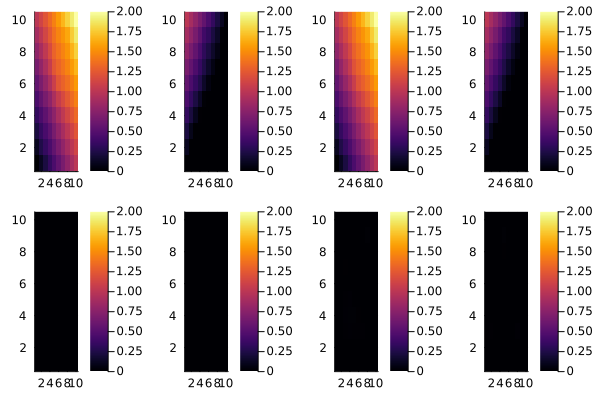

In [6]:
pv0 = plot_voltages(u0s_true)
pv1 = plot_voltages(u1s_true)
plot(pv0,pv1,layout = @layout [a b])

## Plot of dissipated power data

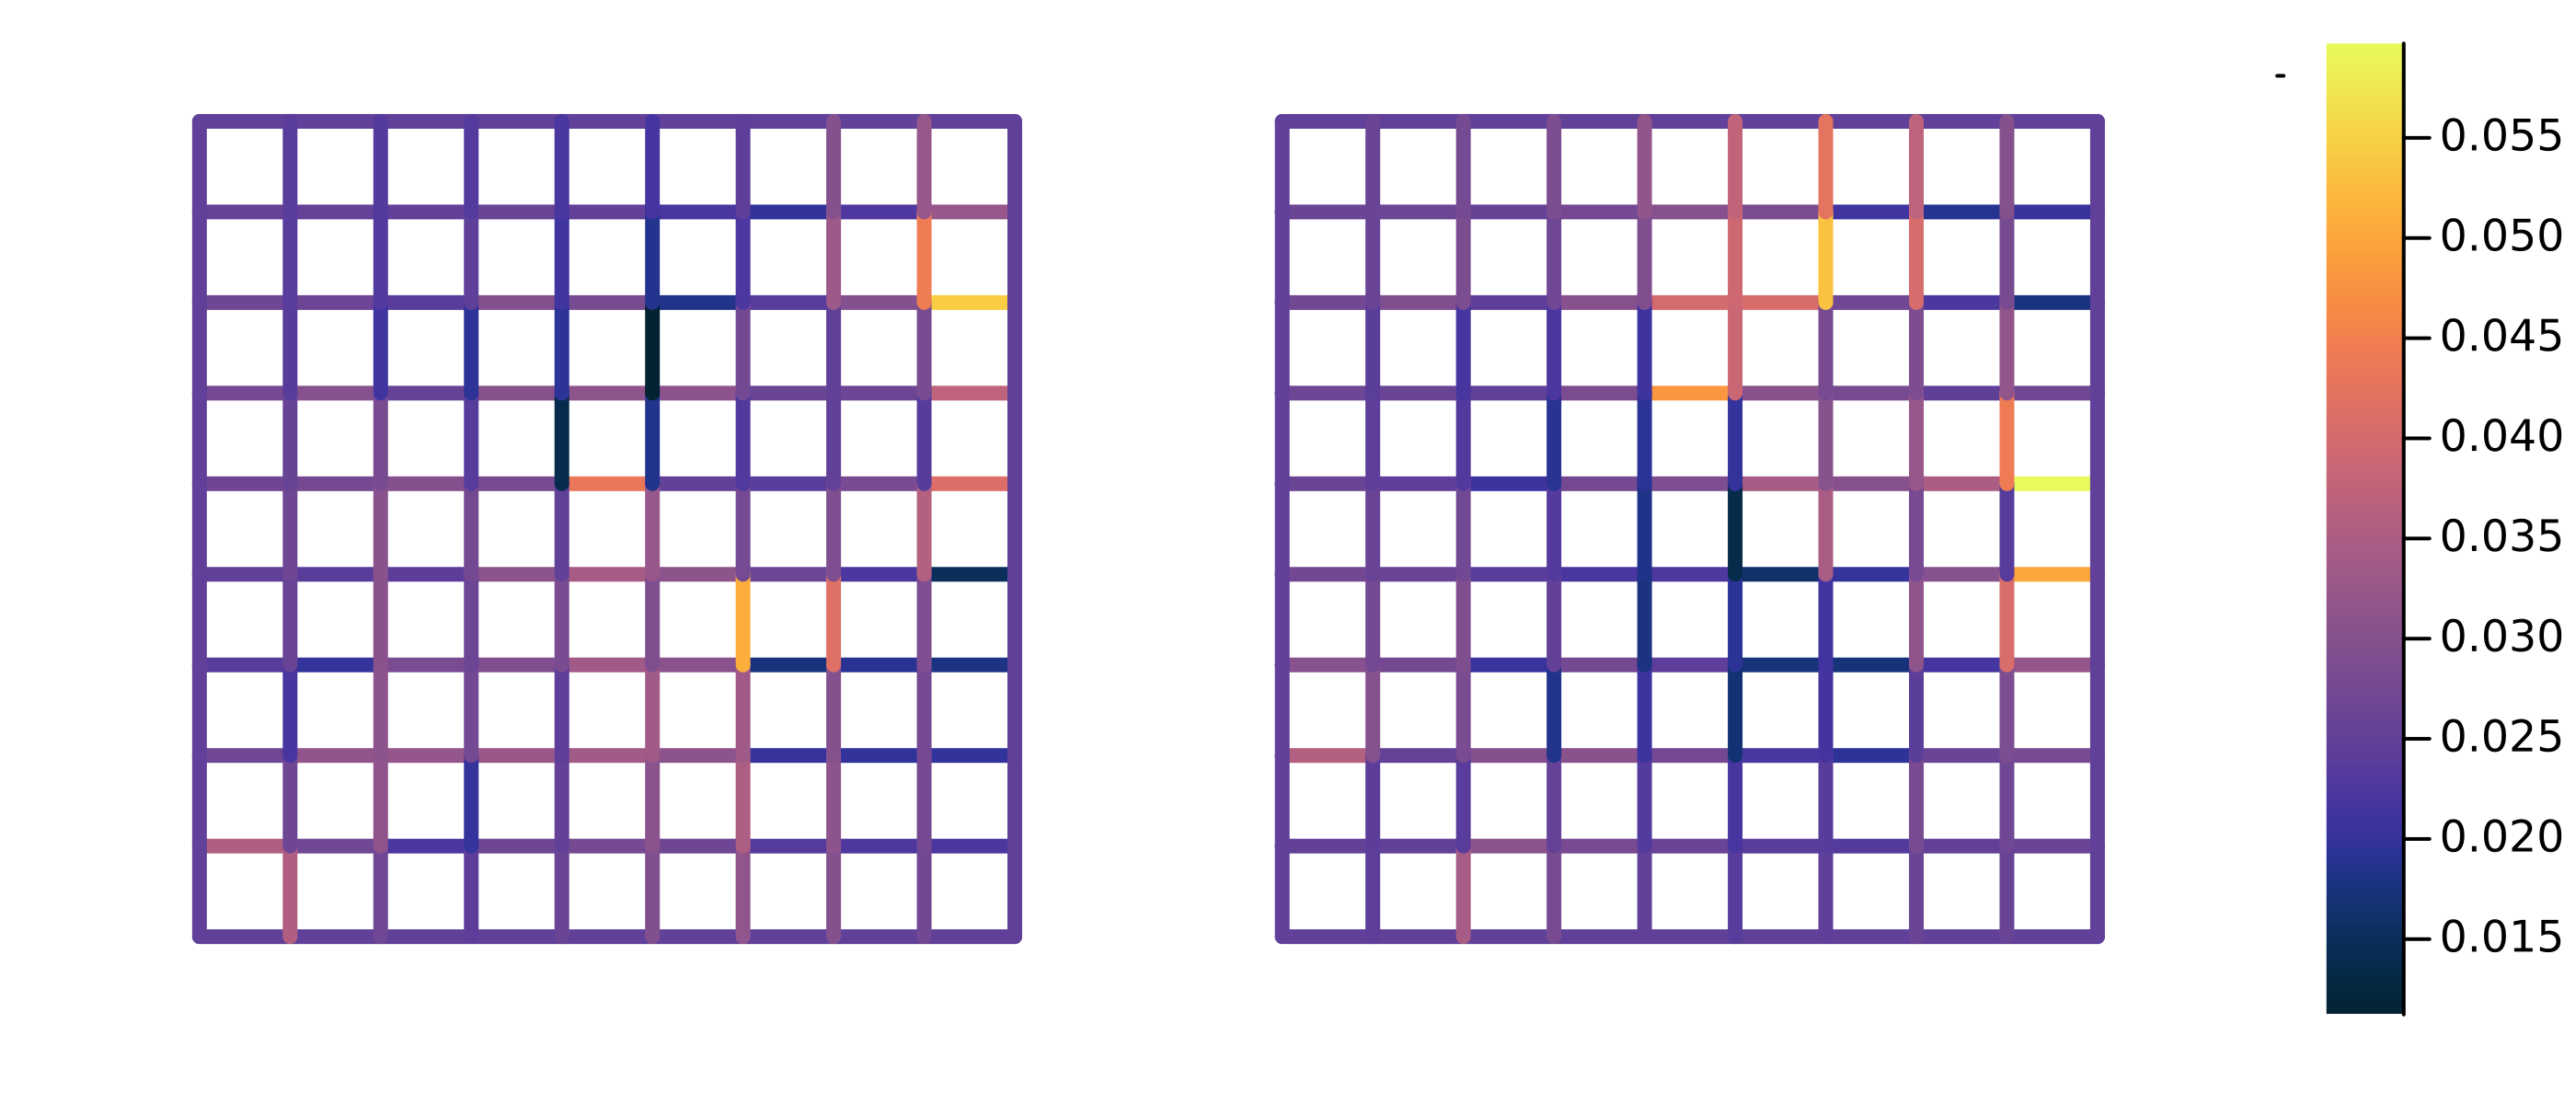

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [7]:
p0 = plot_dissipated_power(Hs0_true)
p1 = plot_dissipated_power(Hs1_true)

# output
l = @layout [ a b c{0.1w} ]
savefig(p0[3],"cplx0_dissipated_power_cbar.png")
savefig(p0[1],"cplx0_dissipated_power1.png")
savefig(p0[2],"cplx0_dissipated_power2.png")
plot(p0...,layout=l, size=(700,300))

savefig(p1[3],"cplx1_dissipated_power_cbar.png")
savefig(p1[1],"cplx1_dissipated_power1.png")
savefig(p1[2],"cplx1_dissipated_power2.png")
plot(p1...,layout=l, size=(700,300))

## Gauss-Newton method
Here we solve the optimization problem
$$
\min_x \| R(x) \|^2,
$$
where $R$ is the residual of a (nonlinear) system of equations describing the
problem. The Gauss-Newton method consists of the update:
$$
x^{(n+1)} = x^{(n)} - (DR(x^{(n)})DR^T(x^{(n)}) + \alpha^2 I)^{-1} DR^T(x^{(n)}) R(x^{(n)}),
$$
where $DF(x)$ is the Jacobian of $F$ evaluated at $x$ and $|alpha$ is a
regularization parameter. We add Armijo backtracking to avoid taking steps
that are too large (based on the  unregularized objective function)

In [8]:
function gauss_newton(R,DR,x0;
    maxiter=100,  # max number of GN iterations
    tol=1e-4,     # gradient tolerance
    α=1e-3,       # regularization parameter
    btα=1e-4,     # SDC for backtracking
    β=1/2,        # Armijo factor
    btmaxiter=100 # backtracking max iter
)
    x = x0
    objfun = []
    f(x) = norm(R(x))^2  # objective function

    for n=1:maxiter
        J = DR(x)
        r = R(x)
        ∇f = 2J'*r
        push!(objfun,f(x))
        norm(∇f) < tol && return x,objfun
        dx = - (J'*J + α^2*I)\(J'*r) # GN direction
        # backtracking line search
        t = 1; k = 1
        for k=1:btmaxiter
            # note: the quantity ∇f'*dx should be real
            (f(x+t*dx)-f(x) < btα*t*real(∇f'*dx)) && break
            t*=β
            (k==btmaxiter) && println("Warning: max backtracking limit hit")
        end
        x = x + t*dx
    end
    return x,objfun
end

gauss_newton (generic function with 1 method)

## Setup data and residual
We check numerically whether the Jacobian we calculate satisfies
$$
 F(x + \epsilon \delta x) = F(x) + \epsilon DF(x)\delta x + \mathcal{O}(\epsilon^2).
$$
More concretely, if $\epsilon$ is too large, Taylor's theorem doesn't hold, if
it is too small then we encounter problems with machine precision, so if
divide the purportedly $\mathcal{O}(\epsilon^2)$ term by $\epsilon^2$ we
should get something approximately constant (for values of $\epsilon$ that are
neither too big or too small)

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


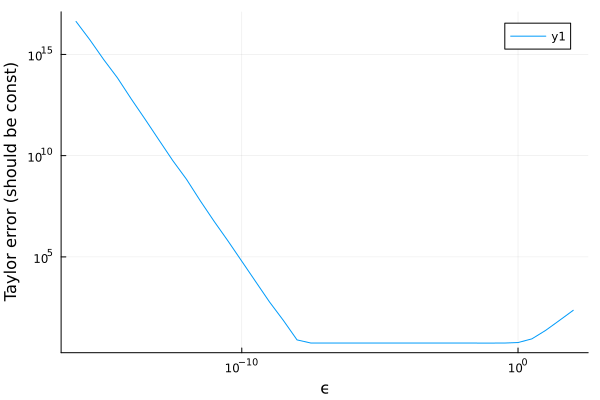

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [9]:
function unpack(x)
 σr=real(x[1:n𝐄])
 σi=real(x[n𝐄 .+ (1:n𝐄)])
 us = permutedims(reshape(x[2n𝐄 .+ (1:3N*n𝐕)],n𝐕,3,N),[1,3,2])
 return (σr,σi,us0=us[:,:,1],us1=us[:,:,2],us1b=us[:,:,3])
end
function pack(σr,σi,us0,us1,us1b)
 us = permutedims(cat(us0,us1,us1b,dims=3),[1,3,2])
 return vcat(σr,σi,us[:])
end
noiselevel = 1/100
Random.seed!(17) # initialize seed
Hs0_noisy = Hs0_true + maximum(Hs0_true)*noiselevel*randn(size(Hs0_true))
Hs1_noisy = Hs1_true + maximum(Hs1_true)*noiselevel*randn(size(Hs1_true))
R(x)  = fwd(unpack(x)...) - rhs(fs,Hs0_true,Hs1_true)
Rnoisy(x)  = fwd(unpack(x)...) - rhs(fs,Hs0_noisy,Hs1_noisy)
DR(x) = jacobian(unpack(x)...)

# test Jacobian against Taylor's theorem
ϵs = 10.0 .^ (2:-0.5:-16)
jacobian_test(F,DF,x0,δx) =
 [ norm(F(x0 + ϵ*δx) - (F(x0) + ϵ*DF(x0)*δx))/ϵ^2/norm(δx) for ϵ ∈ ϵs ]

x_true = pack(σ_true_r,σ_true_i,u0s_true,u1s_true,conj(u1s_true))
x_ref  = pack(σ_ref_r, σ_ref_i, u0s_ref, u1s_ref, conj(u1s_ref))

plot(ϵs, jacobian_test(R,DR,x_true,randn(2n𝐄+3N*n𝐕)),
      scale=:log10,xlabel="ϵ",ylabel="Taylor error (should be const)")

## Reconstructions with and without noise

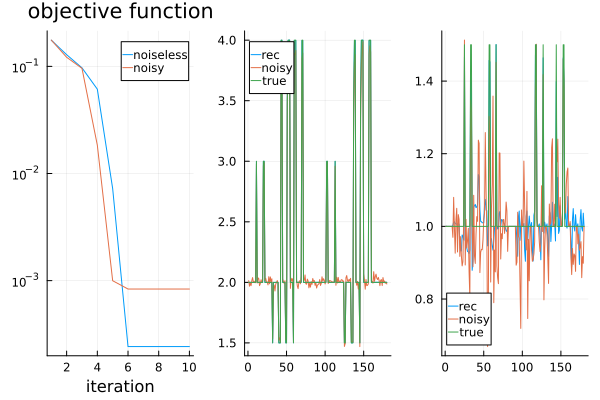

In [10]:
X,objfun1=gauss_newton(R,DR,x_ref;α=2e-3,tol=1e-6,maxiter=10)
xrec1 = unpack(X)

X,objfun2=gauss_newton(Rnoisy,DR,x_ref;α=1e-2,tol=1e-6,maxiter=10)
xrec2 = unpack(X)

p1 = plot(objfun1,yscale=:log10,label="noiseless")
p1 = plot!(objfun2,title="objective function",label="noisy",xlabel="iteration")
p2 = plot(xrec1.σr,label="rec"); p2=plot!(xrec2.σr,label="noisy"); p2=plot!(σ_true_r,label="true");
p3 = plot(xrec1.σi,label="rec"); p3=plot!(xrec2.σi,label="noisy"); p3=plot!(σ_true_i,label="true");
plot(p1,p2,p3,layout=grid(1,3))

## Plot for paper

relative error σrec1 = 1.7427685165405788 %
relative error σrec2 = 4.542127213663923 %
relative error σrec1 / real = 0.034668770691634425 %
relative error σrec2 / real = 1.9815326713300547 %
relative error σrec1 / imag = 4.255403263789608 %
relative error σrec2 / imag = 10.176124619190345 %


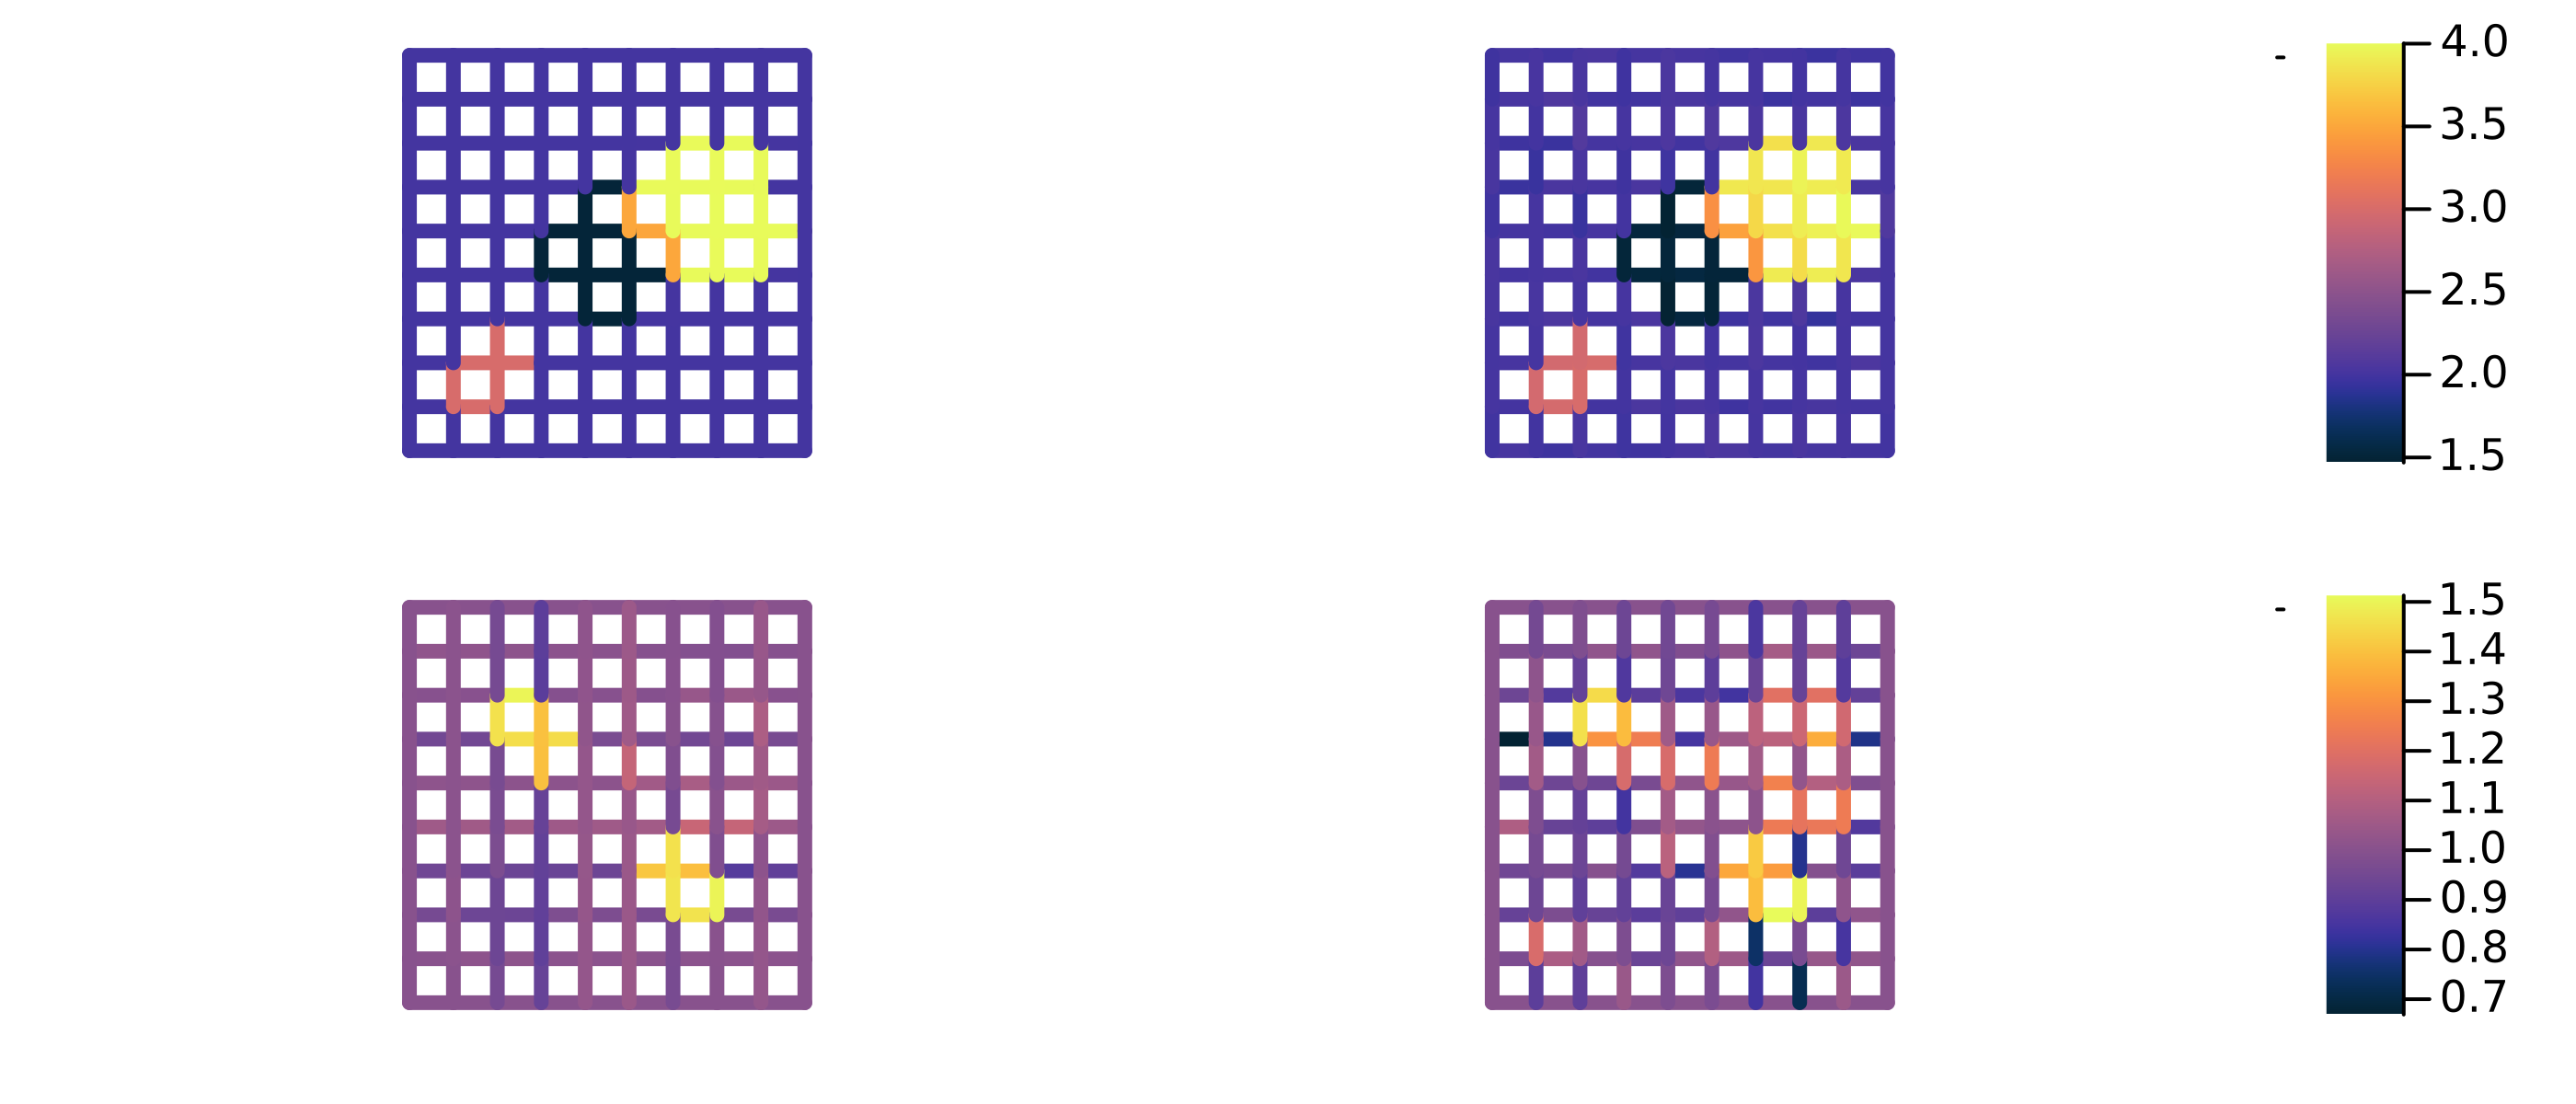

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [11]:
relerr(a,b) = norm(a-b)/norm(a)
println("relative error σrec1 = ",100*relerr(σ_true_r+im*ω*σ_true_i,xrec1.σr+im*ω*xrec1.σi)," %")
println("relative error σrec2 = ",100*relerr(σ_true_r+im*ω*σ_true_i,xrec2.σr+im*ω*xrec2.σi)," %")
println("relative error σrec1 / real = ",100*relerr(σ_true_r,xrec1.σr)," %")
println("relative error σrec2 / real = ",100*relerr(σ_true_r,xrec2.σr)," %")
println("relative error σrec1 / imag = ",100*relerr(σ_true_i,xrec1.σi)," %")
println("relative error σrec2 / imag = ",100*relerr(σ_true_i,xrec2.σi)," %")

function plot_reconstructions(σrec1,σrec2)
  clims = extrema([σrec1 σrec2])

  l = @layout [ grid(1,2) a{0.1w} ]; dpi=400; h=1*dpi; cw = h/4;
  # Colorbar
  h2 = scatter([0,0], [0,1], zcolor=[0,1], clims=clims,
                   xlims=(1,1.1), label="", c=:thermal, framestyle=:none,
                   size=(cw,h),dpi=dpi)
  p1 = plot_edge_quantity(σrec1,lw=4,clims=clims)
  plot!(p1,size=(h,h),dpi=dpi)
  p2 = plot_edge_quantity(σrec2,lw=4,clims=clims)
  return p1,p2,h2
end

# output
p1,p2,h2 = plot_reconstructions(xrec1.σr,xrec2.σr)
savefig(p1,"sigrec_r_noiseless.png")
savefig(p2,"sigrec_r_noisy.png")
savefig(h2,"sigrec_r_cbar.png")
z1 = plot(p1,p2,h2,layout=l,size=(700,300))

p1,p2,h2 = plot_reconstructions(xrec1.σi,xrec2.σi)
savefig(p1,"sigrec_i_noiseless.png")
savefig(p2,"sigrec_i_noisy.png")
savefig(h2,"sigrec_i_cbar.png")
z2 = plot(p1,p2,h2,layout=l,size=(700,300))

plot(z1,z2,layout=grid(2,1))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*